In [1]:
import sys
sys.path.append('../')

In [6]:
import os
import argparse
import yaml
import wandb
import random
import time

import math
import numpy as np
import torch
torch.backends.cudnn.benchmark = True
import torch.nn as nn

from data.dataset import SegmentDataset
from data.transforms import transform
from data.collate import collate
from torch.utils.data import DataLoader
from models.model import SegmentModel
from models.unet import UNet
from models.utils.loss import PixelLoss
from metrics.metrics import pixelAccuracy, gatherMetrics
from metrics.pred import predict, getMask
from utils.vis import *
from utils.decorators import timer
from utils.parameters import *
from metrics.metrics import bakeWeight
from metrics.utils import conf_operations


In [3]:
version = 'street_v8'

cfg_path = '../configs/{}.yml'.format(version.replace('_', '/').replace('-', '/'))
all_configs = yaml.safe_load(open(cfg_path))

random_seed = int(all_configs['random_seed'])
batch_size = int(all_configs['batch_size'])
num_classes = int(all_configs['num_classes'])
if num_classes==2:
    ftr = all_configs['ftr']
    if ftr.lower()=='street':
        index2name = index2name_street
        color2index = color2index_street
    elif ftr.lower()=='building':
        index2name = index2name_building
        color2index = color2index_building
    else:
        raise ValueError("Unknown feature found - {}".format(ftr))

n_epoch = int(all_configs['n_epoch'])
train_annot = '../'+all_configs['train_annot']
val_annot = '../'+all_configs['val_annot']

H = all_configs['H'] if 'H' in all_configs else 2048
W = all_configs['W'] if 'W' in all_configs else 2048

split_H = all_configs['split_H'] if 'split_H' in all_configs else None
split_W = all_configs['split_W'] if 'split_W' in all_configs else None

random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

train_set = SegmentDataset(
    annot=train_annot, 
    transform=transform, 
    dim=(H, W), 
    c2i=color2index,
    split=(split_H, split_W),
)
train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    num_workers=0,
    collate_fn=collate,
)
val_set = SegmentDataset(
    annot=val_annot, 
    transform=transform, 
    dim=(H, W), 
    c2i=color2index,
    split=(split_H, split_W),
)
val_loader = DataLoader(
    val_set,
    batch_size=batch_size,
    num_workers=0,
    collate_fn=collate,
)

/content/data/paris/paris359_image.png /content/data/paris/paris359_labels.png torch.Size([3, 512, 512]) torch.Size([512, 512])


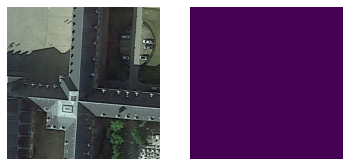

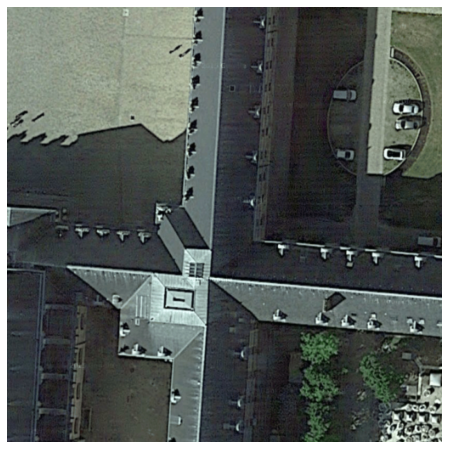

/content/data/chicago/chicago426_image.png /content/data/chicago/chicago426_labels.png torch.Size([3, 512, 512]) torch.Size([512, 512])


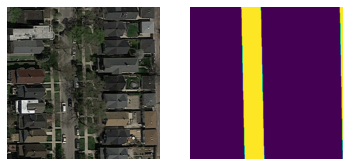

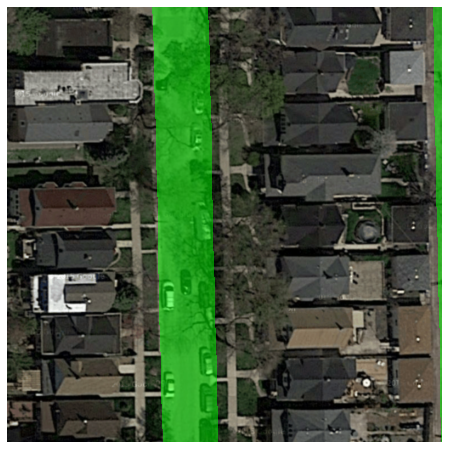

/content/data/berlin/berlin147_image.png /content/data/berlin/berlin147_labels.png torch.Size([3, 512, 512]) torch.Size([512, 512])


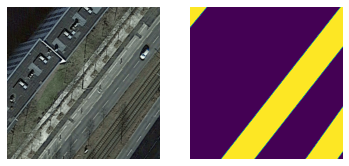

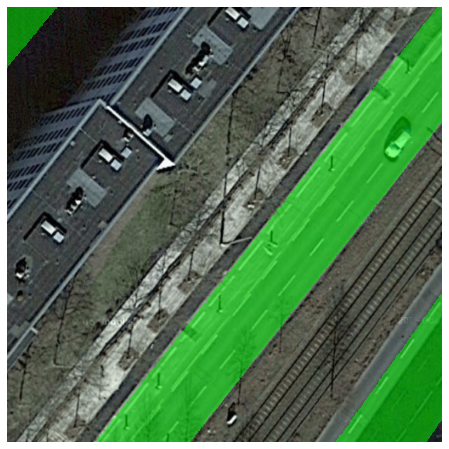

/content/data/chicago/chicago61_image.png /content/data/chicago/chicago61_labels.png torch.Size([3, 512, 512]) torch.Size([512, 512])


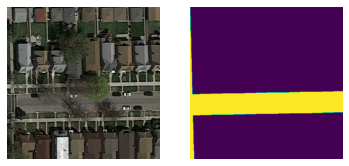

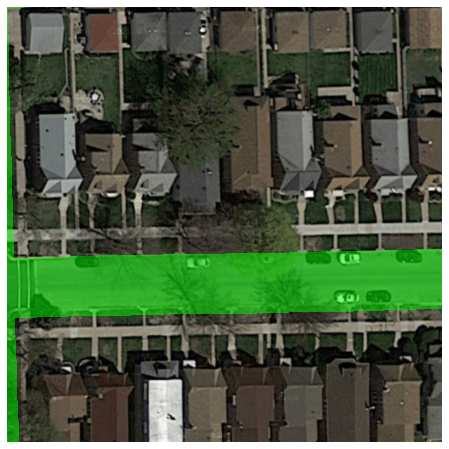

/content/data/chicago/chicago276_image.png /content/data/chicago/chicago276_labels.png torch.Size([3, 512, 512]) torch.Size([512, 512])


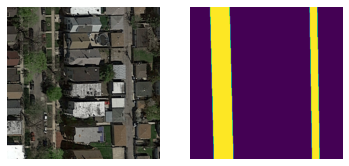

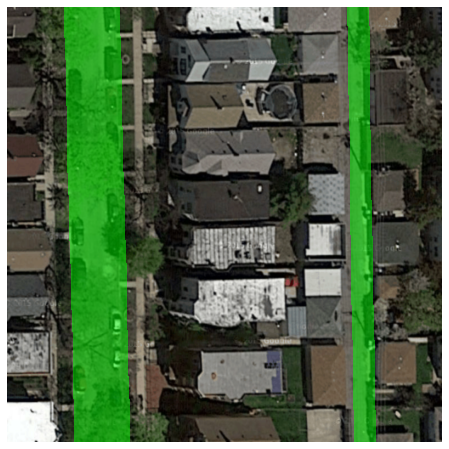

/content/data/paris/paris228_image.png /content/data/paris/paris228_labels.png torch.Size([3, 512, 512]) torch.Size([512, 512])


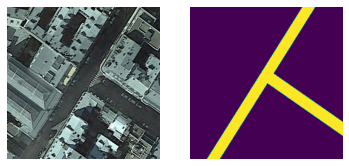

In [ ]:
for i, x in enumerate(val_loader):
    print(x[0][0], x[1][0], x[2][0].shape, x[3][0].shape)
    showImageMask(x[2][0].permute(1, 2, 0), x[3][0], use_path=False, debug=True, overlay=False)
    showImageMask(x[2][0].permute(1, 2, 0), x[3][0], use_path=False, debug=True, overlay=True)
    if i==5:
        break